In [1]:
# import modules
import copy
from sys import path
from collections import defaultdict

In [2]:
import numpy as np
import pandas as pd
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split

In [3]:
path.append('../code/src')

In [4]:
import svd_constraint
from post_rec import PostRec
from inter_rec import InterRec
from evaluate import Evaluation as ev

In [5]:
# constants
# file path
input_path = "../data/"
output_path = '../result/'
rate_file = 'reduced_rating_data.csv'
attr_file = 'recipe_data.csv'

# user/item max
user_max = 1000
food_max = 5000

In [6]:
# Dictionary keys
rs1 = 'w/o Constraint'

k_list = [10, 50, 100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000]

In [7]:
val_dict = {

}

for k in k_list:
    val_dict[k] = 0

keys = [rs1]

result = {key: copy.deepcopy(val_dict) for key in keys}

# Evaluate nDCG w/o Constraint

In [8]:
# Source From: https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    ret = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        ret[int(uid)] = [int(i) for i, r in top_n[uid]]
    
    return ret

In [9]:
def run_SVD_nDCG(k_list):    
    # get data
    reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 5))
    data = Dataset.load_from_file(input_path + rate_file, reader = reader)
    
    train_set, test_set = train_test_split(data, test_size=0.25)
    predict_set = train_set.build_anti_testset()
    
    # use SVD algorithm
    algo = SVD()
    
    # train
    algo.fit(train_set)
    
    # make prediction
    predict = algo.test(predict_set)
    
    # predict nDCG for test-set
    rel_dict = defaultdict(list)
    for (u, i, r) in test_set:
        if r >= 4:
            rel_dict[int(u)].append(int(i))
    
    r_list = []
    top_n = get_top_n(predict, max(k_list))
    top_n_df = pd.DataFrame.from_dict(top_n, orient='index')
    top_n_df = top_n_df.reindex(columns=[x for x in range(0, max(k_list))])
    
    for k in k_list:
        r = ev.calculate_ndcg(rel_dict, top_n_df, k)
        r_list.append(r)
    
    return r_list

In [10]:
r_list = run_SVD_nDCG(k_list)
for idx, k in enumerate(k_list):
    result[rs1][k] = r_list[idx]

<AxesSubplot:>

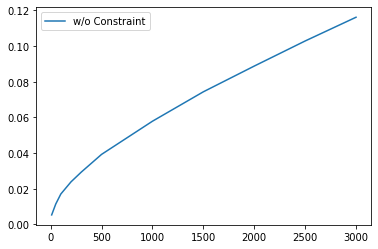

In [11]:
result_df = pd.DataFrame.from_dict(result)
result_df.plot()